<a href="https://colab.research.google.com/github/JorgeZarama/DeepLearning/blob/main/Formato_Entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b><br><h1>
Redes Neuronales y Deep Learning: Proyecto de programación<br>
Deep Vision in classification tasks
<br>
</center></b></h1>

##Autores:

><font color=red>Jhon Panqueva Rodriguez</font><br>
><font color=red>Jorge Gálvez Fujishima</font><br>
><font color=red>Jorge Zarama Benavides</font><br>

###Conjunto de Datos: Plant Seedlings Classification
https://www.kaggle.com/c/plant-seedlings-classification/data

### Estrategia 1: Entrenar desde cero o *from scratch*

La primera estrategia a comparar será una **red neuronal profunda** que el **alumno debe diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que el alumno utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).


1.   **Carga** del conjunto de datos y Acondicionamiento

In [ ]:
!pip install kaggle
!mkdir -p /content/.kaggle
import os
import json

token = {"username":"jpanqq","key":"07bf1f71c9c6d54aa0fae40192c84a6f"}

# Guardar las credenciales de Kaggle
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

# Cambiar los permisos
!chmod 600 /content/.kaggle/kaggle.json

# Configura el path de kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!kaggle competitions download -c plant-seedlings-classification
!unzip -o plant-seedlings-classification.zip -d plant_seedlings_data > unzip.txt
!tail -20 unzip.txt

100% 1.68G/1.69G [00:59<00:00, 32.5MB/s]
100% 1.69G/1.69G [00:59<00:00, 30.5MB/s]
  inflating: plant_seedlings_data/train/Sugar beet/f30abde8b.png  
  inflating: plant_seedlings_data/train/Sugar beet/f40d6554c.png  
  inflating: plant_seedlings_data/train/Sugar beet/f474da0ca.png  
  inflating: plant_seedlings_data/train/Sugar beet/f506aa640.png  
  inflating: plant_seedlings_data/train/Sugar beet/f5e7d66b9.png  
  inflating: plant_seedlings_data/train/Sugar beet/f72176e1a.png  
  inflating: plant_seedlings_data/train/Sugar beet/f78fcd305.png  
  inflating: plant_seedlings_data/train/Sugar beet/f7ac77334.png  
  inflating: plant_seedlings_data/train/Sugar beet/f861c27a9.png  
  inflating: plant_seedlings_data/train/Sugar beet/f8bf223f3.png  
  inflating: plant_seedlings_data/train/Sugar beet/f9a842f5f.png  
  inflating: plant_seedlings_data/train/Sugar beet/faaac2544.png  
  inflating: plant_seedlings_data/train/Sugar beet/fb57ce659.png  
  inflating: plant_seedlings_data/train/Sugar b

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Directorio del dataset
base_dir = '/content/plant_seedlings_data/train'
class_names = os.listdir(base_dir)

tamano_image = 64
# Leer imágenes y etiquetas
images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(tamano_image, tamano_image))
        images.append(img_to_array(img))
        labels.append(class_name)

# Convertir a arrays de numpy normalizado
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

# Codifica las etiquetas
encoderLabels = LabelEncoder()
encoded_labels = encoderLabels.fit_transform(labels)

# Dividir el dataset en conjuntos de entrenamiento y test
x_tr, x_test, y_tr, y_test = train_test_split(images, encoded_labels, test_size=0.1, random_state=42)

print(x_tr.shape)
print(y_tr.shape)
print("Clases codificadas:", np.unique(y_tr))

(4275, 64, 64, 3)
(4275,)
Clases codificadas: [ 0  1  2  3  4  5  6  7  8  9 10 11]


2.   **Inspección** del conjunto de datos

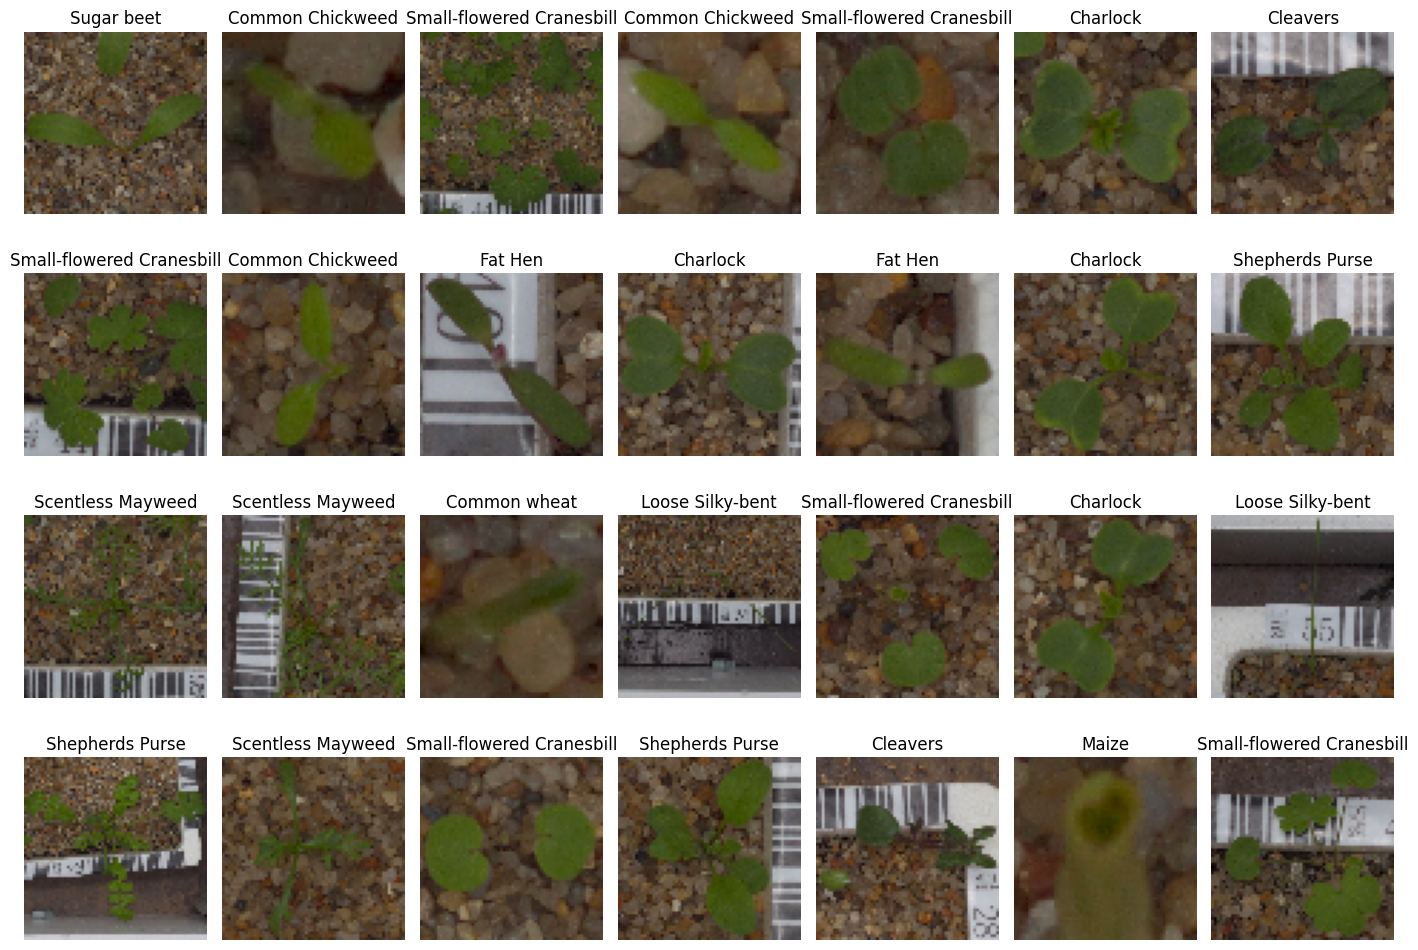

In [ ]:
# Inspección del conjunto de datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 10))

# Queremos mostrar 28 imágenes
for n in range(1, 29):
    fig.add_subplot(4, 7, n)

    # Obtener imagen y etiqueta
    img = x_tr[n]
    label = encoderLabels.inverse_transform([y_tr[n]])[0]  # Convertir etiqueta codificada de nuevo a su nombre original

    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()



3.   **Funciones base** Carga de funciones base.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from typing import Tuple

def capture_classification_report(model: Model, x, y) -> str:
    predictions = model.predict(x, batch_size=128)
    report = classification_report(y, predictions.argmax(axis=1), output_dict=False)
    return report

def visualize_and_evaluate_model(model, H, x, y, custom_text=""):
    # Capture only the classification report
    classification_text = capture_classification_report(model, x, y)

    # Get epochs for plotting
    epochs = len(H.history["loss"])

    # Create a subplot layout
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("Plant Seedlings Classification architecture\n" + custom_text)

    # Plotting training loss and accuracy on the first axis
    ax1.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    ax1.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    ax1.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    ax1.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    ax1.set_title("Training Loss and Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Loss/Accuracy")
    ax1.legend()

    # Constructing model architecture description

    arch_desc = f"Loss Function: {model.loss} \nOptimizer: {type(model.optimizer).__name__}, Epochs: {epochs}\n\n"


    arch_desc += "Model Layers:\n"
    for layer in model.layers:
        arch_desc += f"- {layer.name} ({layer.__class__.__name__})"
        if 'units' in layer.get_config():
            arch_desc += f", units: {layer.get_config()['units']}\n"
        elif 'filters' in layer.get_config():
            arch_desc += f", filters: {layer.get_config()['filters']}\n"
        else:
            arch_desc += "\n"

    # Adding architecture description on the second axis
    ax2.axis('off')
    ax2.text(0.5, 0.5, arch_desc, ha='center', va='center', wrap=True)

    # Adding classification report on the third axis
    ax3.axis('off')
    ax3.text(0.5, 0.5, "Classification Report:\n" + classification_text, ha='center', va='center', wrap=True)

    # Adjust layout to fit everything
    plt.tight_layout()
    plt.show()


## 4. Desarrollo de la Arquitectura de Red Neuronal y Entrenamiento de la Solución

Se realizaron varios experimentos con diferentes arquitecturas de red neuronal. Para cada experimento, se generó una imagen que presenta las curvas de aprendizaje, una descripción de la arquitectura utilizada y una tabla de evaluación.

### Experimento 1: Capas Convolucionales sin Regularización

![Experimento 1](https://datosysoluciones.com/viu/exp1b.png)

Observamos un claro sobreajuste (overfitting) con una precisión (accuracy) del 71%.

### Experimento 2: Regularización con Dropout

- **Dropout al 0.5**

  ![Experimento 2.1](https://datosysoluciones.com/viu/exp2.png)

  La precisión mejora al 79%, pero después de la época 15, se observa de nuevo sobreajuste. Se probará modificando el Dropout a 0.25 y 0.75 para seleccionar la mejor opción.

- **Dropout al 0.25**

  ![Experimento 2.2](https://datosysoluciones.com/viu/exp3.png)

  Con un 71% de precisión, se observa algo de divergencia al final.

- **Dropout al 0.75**

  ![Experimento 2.3](https://datosysoluciones.com/viu/exp4.png)

  En este caso, la convergencia del modelo es más baja con un 69%. El mejor resultado se obtuvo con 0.5 de Dropout, por lo que se mantendrá esta configuración para los siguientes experimentos.

### Experimento 3: Regularización con Batch Normalization

- **Batch Normalization**

  ![Experimento 3.1](https://datosysoluciones.com/viu/exp5.png)

  Con esta normalización, la precisión mejora a 83%, y la convergencia es más rápida.

### Experimento 4: Regularización con L2

- **L2 al "0.001"**

  ![Experimento 3.2](https://datosysoluciones.com/viu/exp6a.png)

  El accuracy de validación disminuye ligeramente, pero el aprendizaje parece mejorar. Aunque persiste el sobreajuste.

- **L2 al "0.01"**

  ![Experimento 3.3](https://datosysoluciones.com/viu/exp7.png)

  La curva de aprendizaje mejora, con menos sobreajuste. Se ejecutará con 100 épocas para verificar mejoras.

  ![Experimento 3.4](https://datosysoluciones.com/viu/exp8.png)

  El resultado es similar al alcanzado en 50 épocas, con un punto máximo de convergencia de 99% en entrenamiento y 83% en validación, pero persiste el sobreajuste.

- **L2 al "0.1"**

  ![Experimento 3.5](https://datosysoluciones.com/viu/exp9.png)

  Aunque la curva mejora, el sobreajuste y la precisión de validación del 85% son problemáticos.

### Experimento 5: Regularización con L1

- **L1 al "0.001"**

  ![Experimento 4.1](https://datosysoluciones.com/viu/12.png)

  No se observan mejoras significativas respecto a L2, por lo que se utilizará L2 al "0.01" en las siguientes actividades.

### Experimento 6: Remover Capa Densa

Se removió una de las dos capas densas.

![Experimento 4.2](https://datosysoluciones.com/viu/exp13.png)

Aunque parece haber un mejor aprendizaje, no se observan mejoras sustanciales tras más épocas.

![Experimento 4.3](https://datosysoluciones.com/viu/exp14.png)

### Experimento 7: Sustituir Flatten por GlobalMaxPooling2D

![Experimento 5.1](https://datosysoluciones.com/viu/exp15b.png)

Se observa una mejora considerable: 93% en entrenamiento y 88% en validación. Se ejecutará de nuevo con más épocas.

![Experimento 5.2](https://datosysoluciones.com/viu/exp16.png)

Con un 91% de validación y 98% en entrenamiento, este es la mejor configuración hasta el momento.

### Experimento 8: Regularizar TOP MODEL.

Incorporamos una capa de dropout con un valor de 0.50 en el top model y observamos los siguientes resultados tras 200 épocas.



![Experimento 5.2](https://datosysoluciones.com/viu/exp17.png)

En este experimento, se alcanzó un 92% en validación y un 95% en entrenamiento. A pesar de que los resultados finales son superiores, la curva de aprendizaje sugiere underfitting, lo que indica que el dropout de 0.5 podría estar causando algún inconveniente.

Posteriormente, realizamos una prueba modificando el valor L2 de las capas densas a 0.001, con la esperanza de mejorar el underfitting.

![Experimento 5.2](https://datosysoluciones.com/viu/exp18.png)

Con un 93% en validación y un 95% en entrenamiento, los datos muestran un comportamiento más adecuado.

Por lo tanto, decidimos mantener el L2 en 0.001 y ejecutar nuevamente el modelo con un dropout de 0.25 y 0.10 en el top model.

![Experimento 5.2](https://datosysoluciones.com/viu/exp19.png)

En este caso con dropout 0.10, logramos un 96% en validación y un 91% en entrenamiento. Aunque hay una mejora en la curva de aprendizaje, como se evidencia con un 95% en muestras del conjunto de test, consideramos que este es el mejor modelo hasta el momento.


In [ ]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Definimos entrada
input = layers.Input(shape=(tamano_image, tamano_image, 3))


cnn_blocks = [32,128,256]

# Variable para mantener la referencia a la última capa añadida
x = input

l2_regularizer = regularizers.l2(0.001)

# Crear los bloques de convolución dinámicamente
for filters in cnn_blocks:
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.5)(x)




#TOP MODEL
x = layers.GlobalMaxPooling2D()(x)
#x = layers.BatchNormalization()(x)
x = layers.Dropout(0.10)(x)

output = layers.Dense(12, activation="softmax")(x)  # 12 clases


model_cnn = Model(inputs=input, outputs=output)

# 4. Mostramos Arquitectura

model_cnn.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0     

[INFO]: Entrenando la red neuronal...
Epoch 1/200
72/72 [==============================] - 15s 28ms/step - loss: 8.0897 - accuracy: 0.1368 - val_loss: 3.2542 - val_accuracy: 0.1123
Epoch 2/200
72/72 [==============================] - 1s 18ms/step - loss: 5.8707 - accuracy: 0.2257 - val_loss: 3.6631 - val_accuracy: 0.1123
Epoch 3/200
72/72 [==============================] - 1s 18ms/step - loss: 5.0125 - accuracy: 0.2924 - val_loss: 3.9686 - val_accuracy: 0.1123
Epoch 4/200
72/72 [==============================] - 1s 18ms/step - loss: 4.5436 - accuracy: 0.3213 - val_loss: 4.0885 - val_accuracy: 0.1123
Epoch 5/200
72/72 [==============================] - 1s 18ms/step - loss: 3.9691 - accuracy: 0.3865 - val_loss: 3.9056 - val_accuracy: 0.1146
Epoch 6/200
72/72 [==============================] - 1s 18ms/step - loss: 3.6636 - accuracy: 0.3947 - val_loss: 3.6402 - val_accuracy: 0.1637
Epoch 7/200
72/72 [==============================] - 1s 18ms/step - loss: 3.3928 - accuracy: 0.4319 - val_los

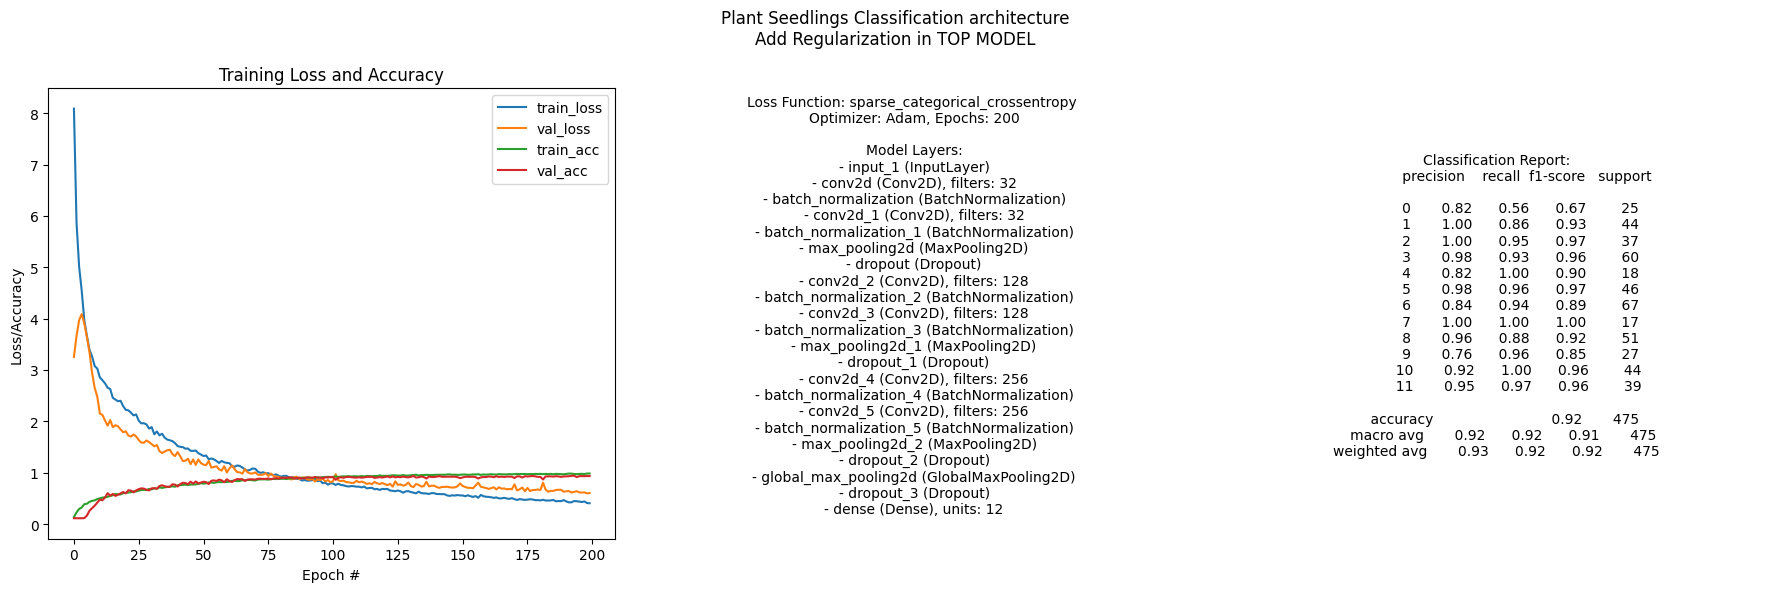

CPU times: user 4min 16s, sys: 15.2 s, total: 4min 31s
Wall time: 4min 32s


In [ ]:
%%time
from tensorflow.keras import backend as K

model_cnn = Model(inputs=input, outputs=output)

model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )


print("[INFO]: Entrenando la red neuronal...")
H = model_cnn.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(model_cnn, H, x_test, y_test, custom_text="Add Regularization in TOP MODEL")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()



**DATA AUMENTATION**

con el fin de disminuir el overfiting y mejorar la prediccion en validacion procedemos a utilizar data aumentation.

In [ ]:
# Crear Image DataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True,
    zoom_range = 0.2
)



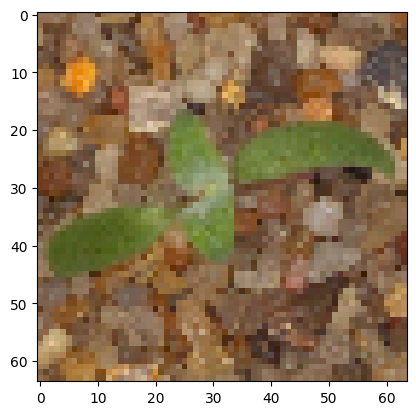

Label = Loose Silky-bent


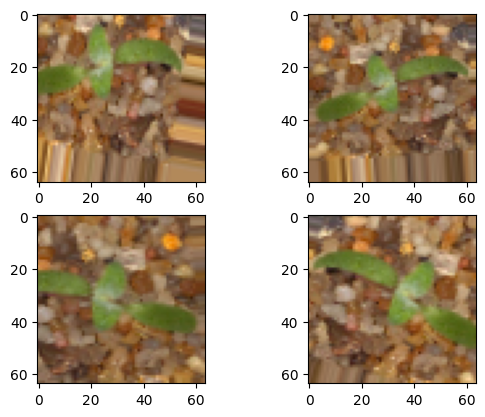

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 10
plt.imshow(image.array_to_img(x_tr[sample]))
plt.show()
print('Label = {}'.format(labels[y_tr[sample]]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(x_tr[sample].reshape((1,tamano_image,tamano_image,3)),batch_size=1):
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

In [ ]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Definimos entrada
input = layers.Input(shape=(tamano_image, tamano_image, 3))


cnn_blocks = [32,128,256]

# Variable para mantener la referencia a la última capa añadida
x = input

l2_regularizer = regularizers.l2(0.001)

# Crear los bloques de convolución dinámicamente
for filters in cnn_blocks:
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.5)(x)


#TOP MODEL
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.10)(x)


output = layers.Dense(12, activation="softmax")(x)  # 12 clases



# Unimos las entradas y salidas del modelo
model_cnn = Model(inputs=input, outputs=output)

# Mostramos Arquitectura

model_cnn.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0     

[INFO]: Entrenando la red neuronal...
Epoch 1/400
71/71 [==============================] - 8s 61ms/step - loss: 0.5736 - accuracy: 0.9356 - val_loss: 0.8072 - val_accuracy: 0.8819
Epoch 2/400
71/71 [==============================] - 4s 56ms/step - loss: 0.5370 - accuracy: 0.9448 - val_loss: 0.7578 - val_accuracy: 0.8807
Epoch 3/400
71/71 [==============================] - 4s 56ms/step - loss: 0.5433 - accuracy: 0.9445 - val_loss: 0.6366 - val_accuracy: 0.9158
Epoch 4/400
71/71 [==============================] - 4s 59ms/step - loss: 0.5346 - accuracy: 0.9437 - val_loss: 0.6484 - val_accuracy: 0.9029
Epoch 5/400
71/71 [==============================] - 4s 57ms/step - loss: 0.5248 - accuracy: 0.9454 - val_loss: 0.8369 - val_accuracy: 0.8725
Epoch 6/400
71/71 [==============================] - 4s 56ms/step - loss: 0.5282 - accuracy: 0.9505 - val_loss: 0.6931 - val_accuracy: 0.8959
Epoch 7/400
71/71 [==============================] - 4s 57ms/step - loss: 0.5183 - accuracy: 0.9481 - val_loss

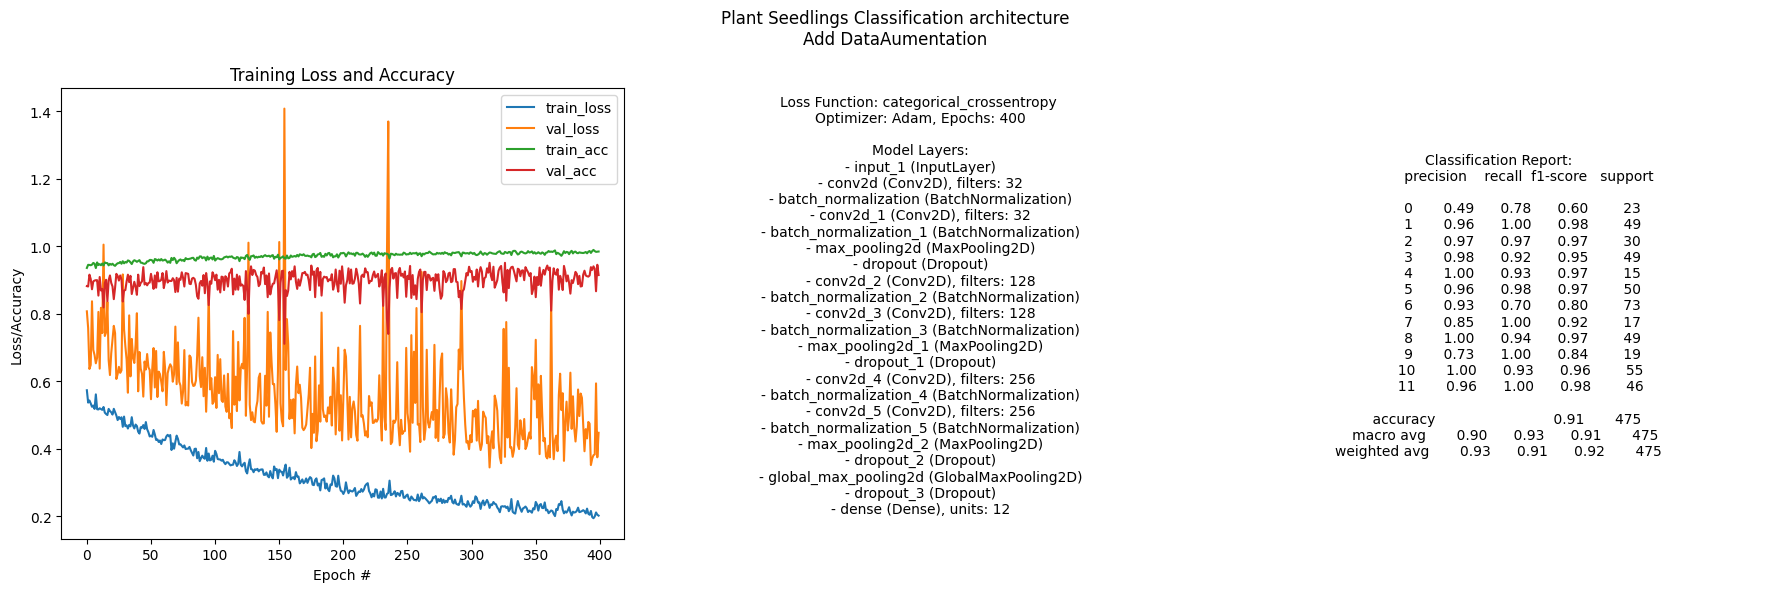

CPU times: user 42min 32s, sys: 54 s, total: 43min 26s
Wall time: 28min 25s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

# Convierte las etiquetas codificadas a one-hot encoding
y_tr_ohe = to_categorical(y_tr)

# separamos los datos de validacion
x_tr_da, x_val_da, y_tr_da, y_val_da = train_test_split(x_tr, y_tr_ohe, test_size=0.2, random_state=42)



model_cnn = Model(inputs=input, outputs=output)

model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
            )


print("[INFO]: Entrenando la red neuronal...")
#H = model_cnn.fit(x_tr, y_tr, epochs=100, batch_size=48, validation_split=0.2)
H = model_cnn.fit(datagen.flow(x_tr_da, y_tr_da, batch_size=48),
                      epochs=400,
                      steps_per_epoch=x_tr_da.shape[0] // 48,
                      validation_data=(x_val_da, y_val_da))

# Learning curves
visualize_and_evaluate_model(model_cnn, H, x_test, y_test, custom_text="Add DataAumentation")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()


Con data augmentation, no obtenemos un resultado mejor que sin ella. Por lo tanto, entendemos que, en este caso específico, no funciona como técnica de regulación.

![Experimento 5.2](https://datosysoluciones.com/viu/exp21a.png)


5.   **Balanceo de muestras**

Se realizó un balanceo de muestras, con data sintética, para esto volvimos a cargar las imágenes en variables nuevas, con nombre diferentes con el fin de no afectar las variables diferentes.

Se crearon tantas imágenes nuevas como fuera necesario para nivelaras.

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.preprocessing import LabelEncoder

# Directorio del dataset
base_dir = '/content/plant_seedlings_data/train'
class_names = os.listdir(base_dir)

tamano_image = 64
# Leer imágenes y etiquetas
images_da = []
labels_da = []

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(tamano_image, tamano_image))
        images_da.append(img_to_array(img))
        labels_da.append(class_name)




In [ ]:
# Calcular la cantidad máxima de fotos por clase
val_max_photos_per_class = np.max(np.unique(labels_da, return_counts=True)[1])

# Crear generador de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterar sobre las clases
for class_name in class_names:
    images_gen = []
    labels_gen = []
    encoded_labels_gen = []
    class_dir = os.path.join(base_dir, class_name)
    list_photos = os.listdir(class_dir)


    for photo in list_photos:
      path_photo = os.path.join(class_dir, photo)
      img_gen = load_img(path_photo, target_size=(tamano_image, tamano_image))
      images_gen.append(img_to_array(img_gen))
      labels_gen.append(class_name)



    images_gen = np.array(images_gen, dtype="float")
    #Codificar las etiquetas
    encoderLabels_gen = LabelEncoder()
    encoded_labels_gen = encoderLabels.fit_transform(labels_gen)

    # Calcular la cantidad de imágenes a generar para igualar la cantidad máxima
    total_images_to_generate = val_max_photos_per_class - len(list_photos)

    if total_images_to_generate > 0:
        batch_size = 16
        num_batches = total_images_to_generate // batch_size
        output_directory = os.path.join(base_dir, class_name)

        # Asegurarse de que el directorio de salida exista
        os.makedirs(output_directory, exist_ok=True)

        # Generar imágenes aumentadas solo para la clase actual
        for i in range(num_batches):
            # print(images_gen)
            # print(labels_gen)
            augmented_images = datagen.flow(images_gen, labels_gen, batch_size=batch_size)
            batch_images, batch_labels = augmented_images.next()

            # Guardar las imágenes aumentadas en el directorio correspondiente
            for j in range(batch_size):
                img = batch_images[j].astype('uint8')
                label = np.argmax(batch_labels[j])

                filename = f"{output_directory}/augmented_image_{i * batch_size + j}_label_{label}.png"
                cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [ ]:
# Directorio del dataset
base_dir = '/content/plant_seedlings_data/train'
class_names = os.listdir(base_dir)

tamano_image = 64
# Leer imágenes y etiquetas
images_da = []
labels_da = []

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(tamano_image, tamano_image))
        images_da.append(img_to_array(img))
        labels_da.append(class_name)

# Convertir a arrays de numpy normalizado
images_da = np.array(images_da, dtype="float") / 255.0
images_da = np.array(images_da)

# Codifica las etiquetas
encoderLabels_da = LabelEncoder()
encoded_labels_da = encoderLabels_da.fit_transform(labels_da)

# Dividir el dataset en conjuntos de entrenamiento y test
x_tr_da_gen, x_test_da_gen, y_tr_da_gen, y_test_da_gen = train_test_split(images_da, encoded_labels_da, test_size=0.2, random_state=42)

print(x_tr_da_gen.shape)
print(y_tr_da_gen.shape)

(6206, 64, 64, 3)
(6206,)


In [ ]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Definimos entrada
input = layers.Input(shape=(tamano_image, tamano_image, 3))


cnn_blocks = [32,128,256]

# Variable para mantener la referencia a la última capa añadida
x = input

l2_regularizer = regularizers.l2(0.001)

# Crear los bloques de convolución dinámicamente
for filters in cnn_blocks:
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu", kernel_regularizer=l2_regularizer)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.5)(x)




#TOP MODEL
x = layers.GlobalMaxPooling2D()(x)
#x = layers.BatchNormalization()(x)
x = layers.Dropout(0.10)(x)

output = layers.Dense(12, activation="softmax")(x)  # 12 clases


model_cnn = Model(inputs=input, outputs=output)

# 4. Mostramos Arquitectura

model_cnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0     

[INFO]: Entrenando la red neuronal...
Epoch 1/200
104/104 [==============================] - 16s 26ms/step - loss: 9.3149 - accuracy: 0.1283 - val_loss: 3.5928 - val_accuracy: 0.0757
Epoch 2/200
104/104 [==============================] - 2s 18ms/step - loss: 5.4103 - accuracy: 0.2162 - val_loss: 3.7118 - val_accuracy: 0.0757
Epoch 3/200
104/104 [==============================] - 2s 18ms/step - loss: 4.3836 - accuracy: 0.2788 - val_loss: 4.0135 - val_accuracy: 0.0797
Epoch 4/200
104/104 [==============================] - 2s 18ms/step - loss: 3.9232 - accuracy: 0.3304 - val_loss: 3.6661 - val_accuracy: 0.1135
Epoch 5/200
104/104 [==============================] - 2s 19ms/step - loss: 3.4259 - accuracy: 0.3775 - val_loss: 3.0709 - val_accuracy: 0.2303
Epoch 6/200
104/104 [==============================] - 2s 19ms/step - loss: 3.2614 - accuracy: 0.4116 - val_loss: 2.7550 - val_accuracy: 0.2633
Epoch 7/200
104/104 [==============================] - 2s 18ms/step - loss: 3.0787 - accuracy: 0.

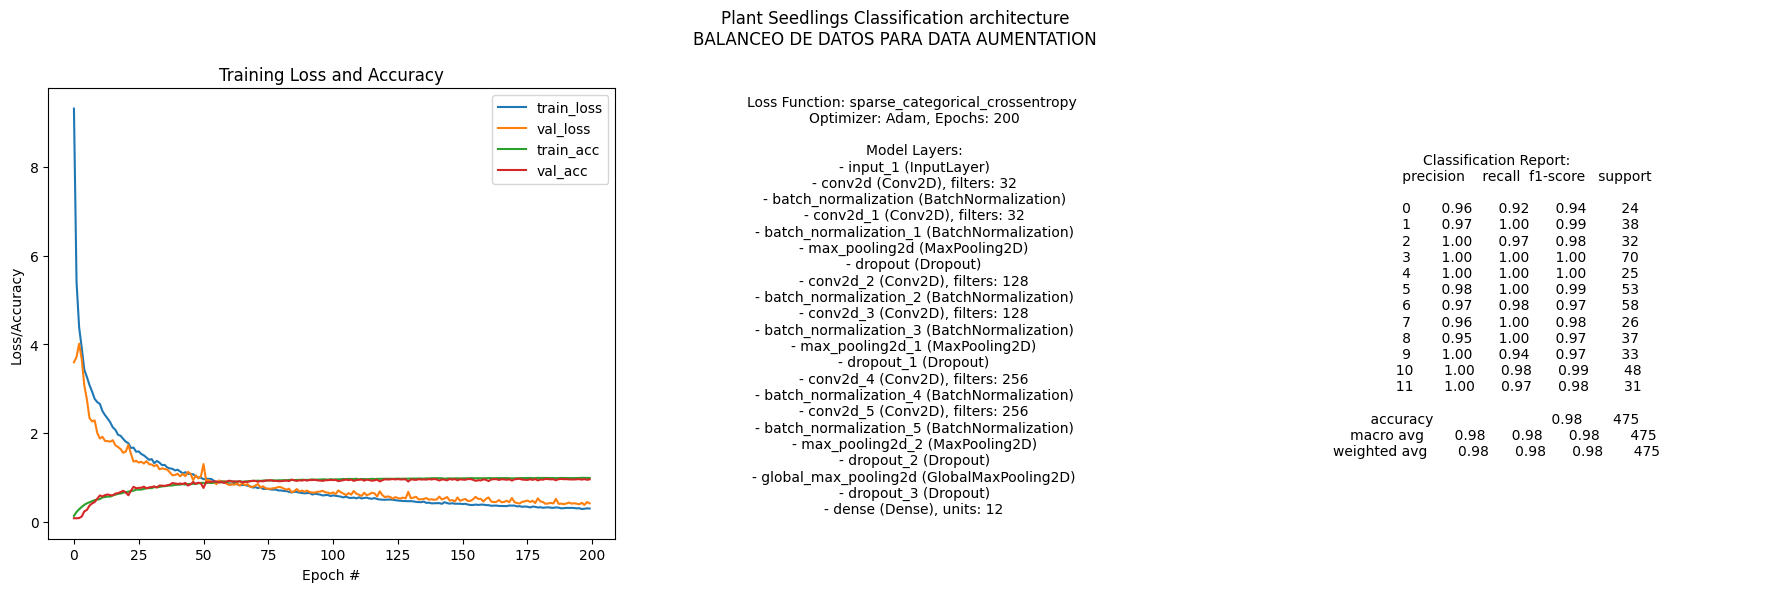

In [ ]:
%%time
from tensorflow.keras import backend as K

model_cnn = Model(inputs=input, outputs=output)

model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

# Entrenamos el perceptrón multicapa
print("[INFO]: Entrenando la red neuronal...")
H = model_cnn.fit(x_tr_da_gen, y_tr_da_gen, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(model_cnn, H, x_test, y_test, custom_text="BALANCEO DE DATOS PARA DATA AUMENTATION")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()


![Experimento 5.2](https://datosysoluciones.com/viu/exp19.png)

Este experimento usando datos generados para balancear el dataset de entrenamiento funciono, siendo este el mejor modelo que tenemos hasta el momento.

6.  **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

![Experimento 5.2](https://datosysoluciones.com/viu/exp27.png)

Como podemos observar, en el conjunto de test alcanzamos un 0.98 con el modelo que nos dio el mejor resultado en el experimento.




<center><b><br><h2>
Conclusiones
</center></b></h2>


1. **Sobreajuste en Modelos Iniciales**: Los primeros experimentos revelaron sobreajuste, con una precisión mayor en entrenamiento que en validación.

2. **Impacto de la Regularización**: La implementación de técnicas de regularización como Dropout y Batch Normalization mejoró la precisión y redujo el sobreajuste. El ajuste del valor de Dropout fue particularmente efectivo.

3. **Efectividad de Batch Normalization**: La adición de Batch Normalization incrementó notablemente la precisión y la velocidad de convergencia.

4. **Regularización L2 y L1**: Se probaron las técnicas L2 y L1, siendo L2 (especialmente con un valor de 0.01) la más efectiva, utilizada en experimentos posteriores.

5. **Remoción de Capas Densas**: Quitar una de las capas densas no produjo mejoras significativas.

6. **Cambio de Flatten a GlobalMaxPooling2D**: Este cambio mejoró notablemente el modelo, logrando 91% de precisión en validación y 98% en entrenamiento.

7. **Regularización en el Top Model**: La inclusión de una capa de dropout mejoró el rendimiento, pero un valor de 0.5 introdujo underfitting.

8. **Ajuste Fino con L2 y Dropout**: Ajustar L2 a 0.001 y variar los valores de dropout en el top model mostró un balance mejor entre entrenamiento y validación.

9. **Dropout Óptimo de 0.10**: Un dropout de 0.10 en el top model alcanzó el mejor equilibrio, con un 96% en validación y 91% en entrenamiento.

10. **Data Augmentation No Efectiva**: En este escenario, la data augmentation no resultó en mejoras, sugiriendo que no siempre es una técnica útil.

11. **Evaluación Final del Modelo**: El modelo más efectivo alcanzó una precisión del 98% en el conjunto de test. Utilizado técnicas de normalización y DataAumentation para balancear las clases del conjunto de entrenamiento





___

### Estrategia 2: Red pre-entrenada

La segunda estrategia a comparar debe incluir la utilización de una **red preentrenada** con el dataset ImageNet, llevando a cabo tareas de ***transfer learning*** y ***fine-tuning*** para resolver la tarea de clasificación asignada. Deben **compararse al menos dos tipos de arquitecturas** (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe **seleccionar la que mayor precisión proporcione** (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera el uso de todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

1.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución

TRANSFER LEARNING / RESNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential

# Cargar la arquitectura y pesos de ResNet50 preentrenada en ImageNet
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(tamano_image, tamano_image, 3))


# No entrenar el modelo base (congelar sus pesos)
base_model_resnet.trainable = False


#TOP MODEL

pre_trained_model_resnet = Sequential(base_model_resnet)


pre_trained_model_resnet.add(layers.Flatten())
pre_trained_model_resnet.add(layers.Dense(256, activation="relu"))
pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))

#pre_trained_model_resnet.add(base_model_resnet)
#pre_trained_model_resnet.add(layers.GlobalMaxPooling2D())
#pre_trained_model_resnet.add(layers.Dropout(0.10))
#pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))


# Visualizar la estructura del modelo completo
pre_trained_model_resnet.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2097408   
                                                                 
 dense_8 (Dense)             (None, 12)                3084      
                                                                 
Total params: 25688204 (97.99 MB)
Trainable params: 2100492 (8.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


[INFO]: Entrenando la red neuronal...
Epoch 1/200
72/72 [==============================] - 5s 30ms/step - loss: 2.4346 - accuracy: 0.1231 - val_loss: 2.4045 - val_accuracy: 0.1404
Epoch 2/200
72/72 [==============================] - 1s 14ms/step - loss: 2.4175 - accuracy: 0.1228 - val_loss: 2.3987 - val_accuracy: 0.1485
Epoch 3/200
72/72 [==============================] - 1s 14ms/step - loss: 2.4099 - accuracy: 0.1368 - val_loss: 2.3908 - val_accuracy: 0.1415
Epoch 4/200
72/72 [==============================] - 1s 14ms/step - loss: 2.3992 - accuracy: 0.1450 - val_loss: 2.3964 - val_accuracy: 0.1520
Epoch 5/200
72/72 [==============================] - 1s 14ms/step - loss: 2.3978 - accuracy: 0.1421 - val_loss: 2.3896 - val_accuracy: 0.1415
Epoch 6/200
72/72 [==============================] - 1s 14ms/step - loss: 2.3876 - accuracy: 0.1488 - val_loss: 2.3879 - val_accuracy: 0.1251
Epoch 7/200
72/72 [==============================] - 1s 14ms/step - loss: 2.3870 - accuracy: 0.1588 - val_loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


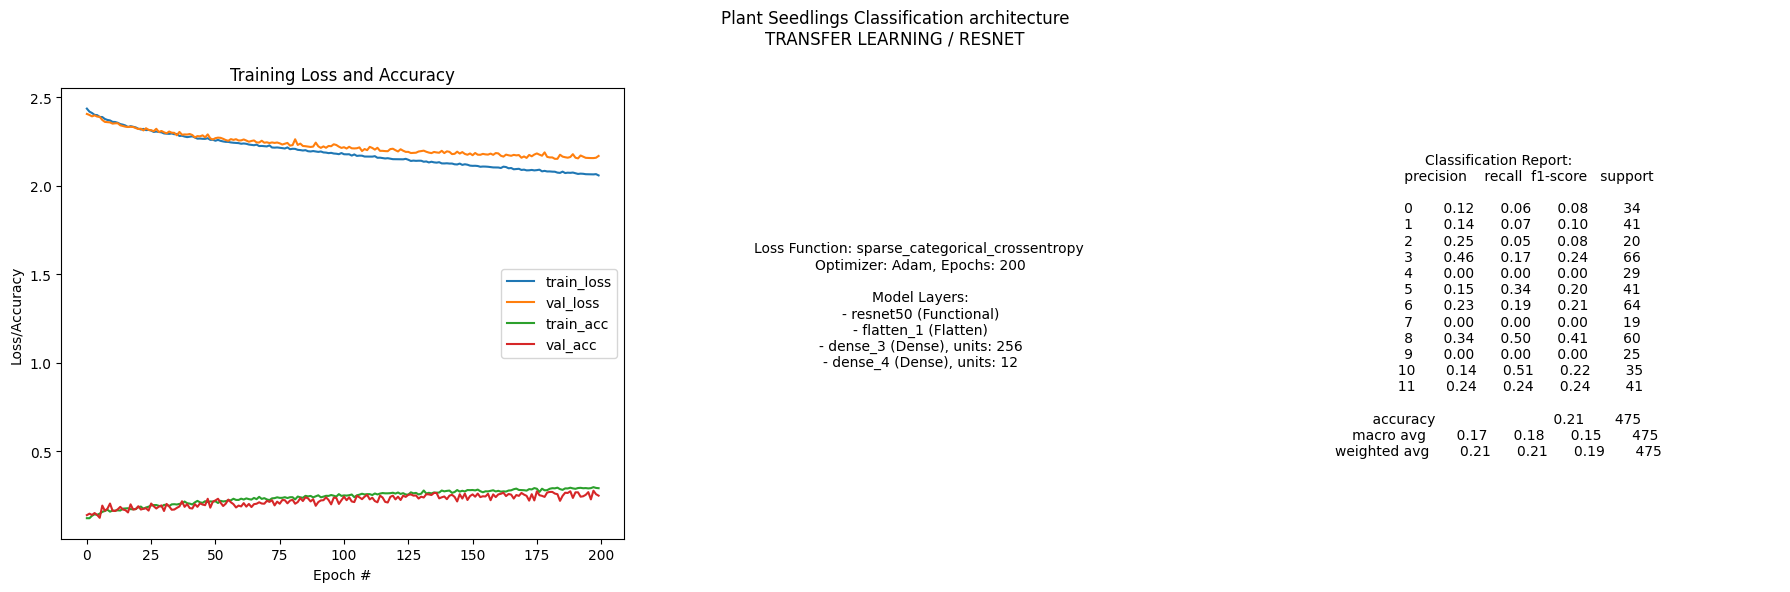

CPU times: user 3min 9s, sys: 11.4 s, total: 3min 20s
Wall time: 3min 33s


8208

In [ ]:
%%time
from tensorflow.keras import backend as K
import gc


pre_trained_model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_resnet.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_resnet, H, x_test, y_test, custom_text="TRANSFER LEARNING / RESNET")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()



![Experimento 5.2](https://datosysoluciones.com/viu/exp23.png)

En la primera imagen, se observa que el ajuste fino no ha logrado converger. Esta falta de convergencia parece deberse a la gran diferencia entre los datos de ImageNet y nuestros datos específicos.


![Experimento 5.2](https://datosysoluciones.com/viu/exp22.png)


En un segundo intento, se aplicó el método de 'dropout' en el modelo superior. Sin embargo, esta estrategia tampoco arrojó resultados satisfactorios.



FINE TUNING *PARTIAL*/ RESNET


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

# Cargar el modelo preentrenado de ResNet
base_model = ResNet50(weights="imagenet",
                      include_top=False,
                      input_shape=(tamano_image, tamano_image, 3))

#inspeccionamos las capas del modelo base
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers


# Cargar la arquitectura y pesos de ResNet50 preentrenada en ImageNet
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(tamano_image, tamano_image, 3))


# No entrenar el modelo base (congelar sus pesos)
#base_model_resnet.trainable = False

# Congelamos las últimas que según la inspección correspoden al ultimo bloque
for layer in base_model_resnet.layers[:-7]:
    layer.trainable = False

#TOP MODEL

pre_trained_model_resnet = Sequential(base_model_resnet)


pre_trained_model_resnet.add(layers.Flatten())
pre_trained_model_resnet.add(layers.Dense(256, activation="relu"))
pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))

#pre_trained_model_resnet.add(pre_trained_model_resnet)
#pre_trained_model_resnet.add(layers.GlobalMaxPooling2D())
#pre_trained_model_resnet.add(layers.Dropout(0.10))
#pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))


# Visualizar la estructura del modelo completo
pre_trained_model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                                 
Total params: 25688204 (97.99 MB)
Trainable params: 5516044 (21.04 MB)
Non-trainable params: 20172160 (76.95 MB)
_________________________________________________________________


[INFO]: Entrenando la red neuronal...
Epoch 1/200
72/72 [==============================] - 7s 35ms/step - loss: 2.3958 - accuracy: 0.1532 - val_loss: 2.4386 - val_accuracy: 0.1275
Epoch 2/200
72/72 [==============================] - 1s 16ms/step - loss: 2.3028 - accuracy: 0.1927 - val_loss: 2.3946 - val_accuracy: 0.1474
Epoch 3/200
72/72 [==============================] - 1s 16ms/step - loss: 2.3045 - accuracy: 0.1942 - val_loss: 2.4753 - val_accuracy: 0.1415
Epoch 4/200
72/72 [==============================] - 1s 16ms/step - loss: 2.3126 - accuracy: 0.1874 - val_loss: 2.3832 - val_accuracy: 0.1462
Epoch 5/200
72/72 [==============================] - 1s 16ms/step - loss: 2.2797 - accuracy: 0.2061 - val_loss: 2.5335 - val_accuracy: 0.1520
Epoch 6/200
72/72 [==============================] - 1s 17ms/step - loss: 2.2890 - accuracy: 0.1909 - val_loss: 2.5600 - val_accuracy: 0.0526
Epoch 7/200
72/72 [==============================] - 1s 17ms/step - loss: 2.2983 - accuracy: 0.1947 - val_loss

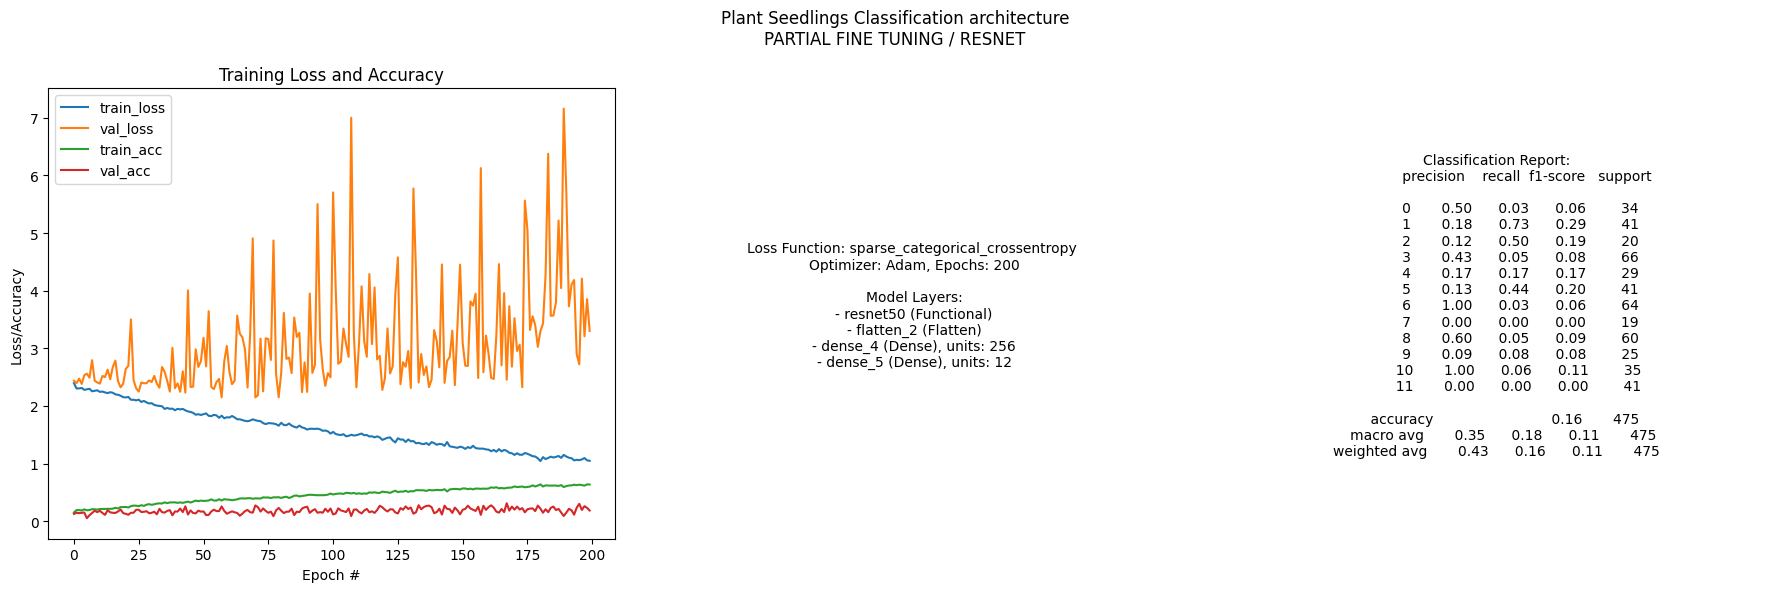

CPU times: user 3min 29s, sys: 11.7 s, total: 3min 40s
Wall time: 3min 51s


112190

In [ ]:
%%time
from tensorflow.keras import backend as K
import gc


pre_trained_model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_resnet.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_resnet, H, x_test, y_test, custom_text="PARTIAL FINE TUNING / RESNET")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()



![Experimento 5.2](https://datosysoluciones.com/viu/exp24.png)

Al aplicar el FINE TUNING parcialmente solo al último bloque, no se observaron mejoras significativas en el conjunto de validación, a pesar de que el conjunto de entrenamiento alcanzó un 63% de eficacia. Esta discrepancia sugiere que el modelo no está generalizando de manera adecuada.

FINE TUNING *COMPLETO*/ RESNET


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers


# Cargar la arquitectura y pesos de ResNet50 preentrenada en ImageNet
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(tamano_image, tamano_image, 3))


#TOP MODEL

pre_trained_model_resnet = Sequential(base_model_resnet)

pre_trained_model_resnet.add(layers.Flatten())
pre_trained_model_resnet.add(layers.Dense(256, activation="relu"))
pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))


#pre_trained_model_resnet.add(layers.GlobalMaxPooling2D())
#pre_trained_model_resnet.add(layers.Dropout(0.10))
#pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))


# Visualizar la estructura del modelo completo
pre_trained_model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 23612300 (90.07 MB)
Trainable params: 23559180 (89.87 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


[INFO]: Entrenando la red neuronal...
Epoch 1/200
72/72 [==============================] - 31s 58ms/step - loss: 3.0454 - accuracy: 0.3310 - val_loss: 10.2476 - val_accuracy: 0.1415
Epoch 2/200
72/72 [==============================] - 3s 44ms/step - loss: 0.7103 - accuracy: 0.7865 - val_loss: 9.9305 - val_accuracy: 0.1263
Epoch 3/200
72/72 [==============================] - 3s 43ms/step - loss: 0.2466 - accuracy: 0.9211 - val_loss: 18.6354 - val_accuracy: 0.1415
Epoch 4/200
72/72 [==============================] - 3s 42ms/step - loss: 0.1392 - accuracy: 0.9553 - val_loss: 31.9341 - val_accuracy: 0.1415
Epoch 5/200
72/72 [==============================] - 3s 41ms/step - loss: 0.0679 - accuracy: 0.9813 - val_loss: 31.2002 - val_accuracy: 0.1427
Epoch 6/200
72/72 [==============================] - 3s 44ms/step - loss: 0.0601 - accuracy: 0.9839 - val_loss: 22.2059 - val_accuracy: 0.1333
Epoch 7/200
72/72 [==============================] - 3s 42ms/step - loss: 0.0380 - accuracy: 0.9886 - va

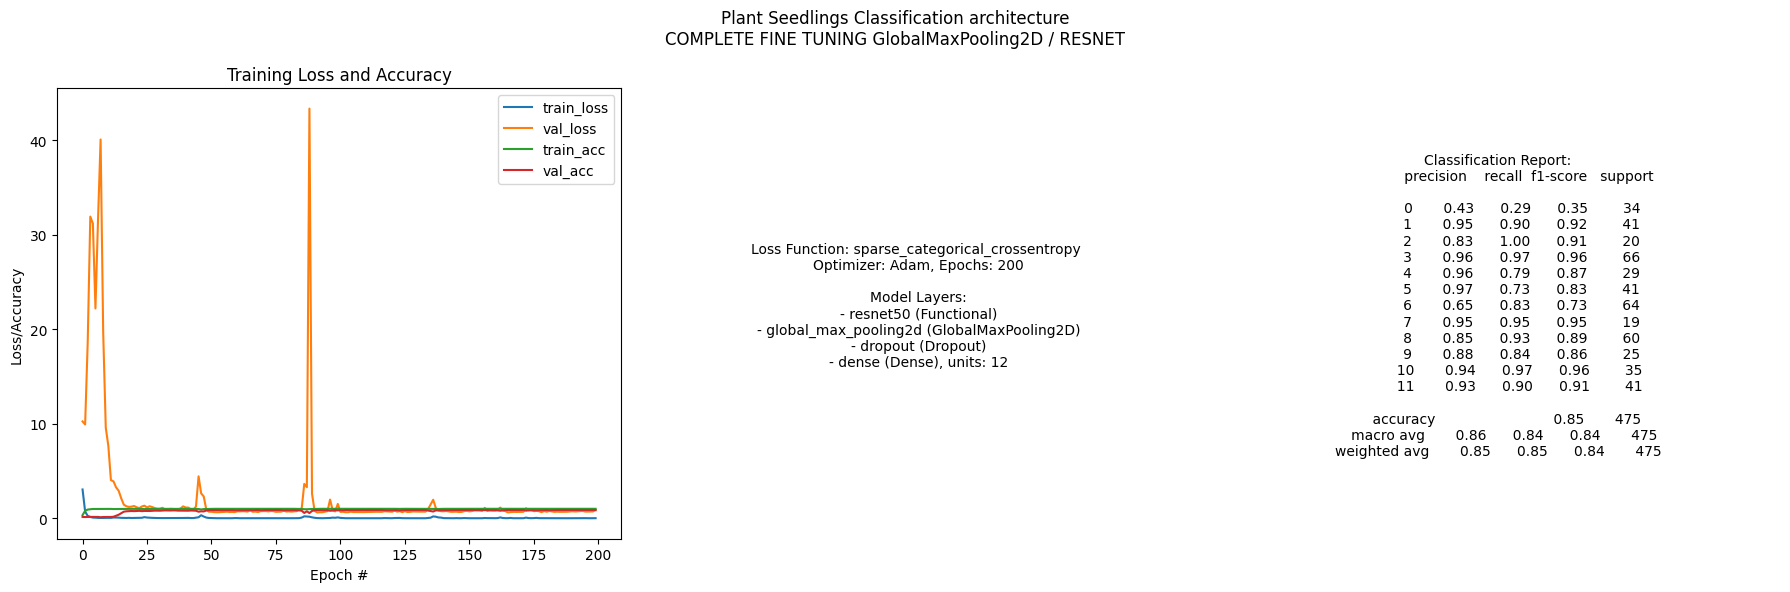

CPU times: user 10min 55s, sys: 14.7 s, total: 11min 10s
Wall time: 10min 50s


116069

In [ ]:
%%time
from tensorflow.keras import backend as K
import gc


pre_trained_model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_resnet.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_resnet, H, x_test, y_test, custom_text="COMPLETE FINE TUNING GlobalMaxPooling2D / RESNET")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()

Con el FINE TUNING completo aplicado, hemos observado un rendimiento del 100% en el conjunto de entrenamiento y un 86% en el de validación, junto con una convergencia más rápida en términos del número de épocas necesarias. Sin embargo, es importante señalar que cada época lleva más tiempo debido a la optimización de un mayor número de parámetros. A pesar de estos resultados, el modelo muestra un nivel preocupante de sobreajuste.

![Experimento 5.2](https://datosysoluciones.com/viu/exp25.png)

Posteriormente, llevamos a cabo un experimento en el que eliminamos las capas DENSAS, las reemplazamos por globalMaxPooling2D y agregamos un 'dropout' del 10%, una configuración que había dado mejores resultados en experimentos anteriores.

![Experimento 5.2](https://datosysoluciones.com/viu/exp26.png)

Los resultados fueron similares, con un 100% en entrenamiento y un 87% en validación. Basándonos en estos datos, concluimos que la red base RESNET no es adecuada para el problema específico que estamos abordando.



TRANSFER LEARNING / VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential

# Cargar la arquitectura y pesos de ResNet50 preentrenada en ImageNet
base_model_VGG16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(tamano_image, tamano_image, 3),
    pooling=None,
    classifier_activation="softmax",
)

# No entrenar el modelo base (congelar sus pesos)
base_model_VGG16.trainable = False

#TOP MODEL

pre_trained_model_VGG16 = Sequential(base_model_VGG16)


pre_trained_model_VGG16.add(layers.Flatten())
pre_trained_model_VGG16.add(layers.Dense(256, activation="relu"))
pre_trained_model_VGG16.add(layers.Dense(12, activation="softmax"))

pre_trained_model_VGG16.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 15242316 (58.14 MB)
Trainable params: 527628 (2.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
%%time
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import gc


pre_trained_model_VGG16.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_VGG16.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_VGG16, H, x_test, y_test, custom_text="TRANSFER LEARNING / VGG16")



#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()

![Experimento 5.2](https://datosysoluciones.com/viu/exp28.png)

Los resultados fueron un 98% en entrenamiento y un 64% en validación. que es un resultado razonable ya que los datos de ImagiNet son muy difernetes a nuestros datos.

*FINE* TUNING  / VGG16


In [ ]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Sequential, models, optimizers

# Cargar el modelo preentrenado de VGG16

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(tamano_image, tamano_image, 3),
    pooling=None,
    #classes=12,
    classifier_activation="softmax",
)

#inspeccionamos las capas del modelo base
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers


base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(tamano_image, tamano_image, 3),
    pooling=None,
    classifier_activation="softmax",
)

# Cargar la arquitectura y pesos de VGG16 preentrenada en ImageNet
base_model_VGG16 = base_model
# No entrenar el modelo base (congelar sus pesos)
#base_model_VGG16.trainable = False

# Congelamos las últimas que según la inspección correspoden al ultimo bloque
# for layer in base_model_VGG16.layers[:-7]:
#     layer.trainable = False

for layer in base_model_VGG16.layers:
  if layer.name == "block5_conv3 ":
    break
  layer.trainable = False
  print("Capa" + layer.name + "congelada...")
#TOP MODEL

pre_trained_model_VGG16 = Sequential(base_model_VGG16)


pre_trained_model_VGG16.add(layers.Flatten())
pre_trained_model_VGG16.add(layers.Dense(256, activation="relu"))
pre_trained_model_VGG16.add(layers.Dense(12, activation="softmax"))



# Visualizar la estructura del modelo completo
pre_trained_model_VGG16.summary()

Capainput_1congelada...
Capablock1_conv1congelada...
Capablock1_conv2congelada...
Capablock1_poolcongelada...
Capablock2_conv1congelada...
Capablock2_conv2congelada...
Capablock2_poolcongelada...
Capablock3_conv1congelada...
Capablock3_conv2congelada...
Capablock3_conv3congelada...
Capablock3_poolcongelada...
Capablock4_conv1congelada...
Capablock4_conv2congelada...
Capablock4_conv3congelada...
Capablock4_poolcongelada...
Capablock5_conv1congelada...
Capablock5_conv2congelada...
Capablock5_conv3congelada...
Capablock5_poolcongelada...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)   

[INFO]: Entrenando la red neuronal...
Epoch 1/200
72/72 [==============================] - 2s 16ms/step - loss: 0.0935 - accuracy: 0.9904 - val_loss: 1.4592 - val_accuracy: 0.6421
Epoch 2/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0899 - accuracy: 0.9909 - val_loss: 1.4548 - val_accuracy: 0.6468
Epoch 3/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0891 - accuracy: 0.9909 - val_loss: 1.4632 - val_accuracy: 0.6386
Epoch 4/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0881 - accuracy: 0.9921 - val_loss: 1.4716 - val_accuracy: 0.6409
Epoch 5/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0876 - accuracy: 0.9904 - val_loss: 1.4842 - val_accuracy: 0.6480
Epoch 6/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0853 - accuracy: 0.9921 - val_loss: 1.4841 - val_accuracy: 0.6292
Epoch 7/200
72/72 [==============================] - 1s 11ms/step - loss: 0.0832 - accuracy: 0.9930 - val_loss

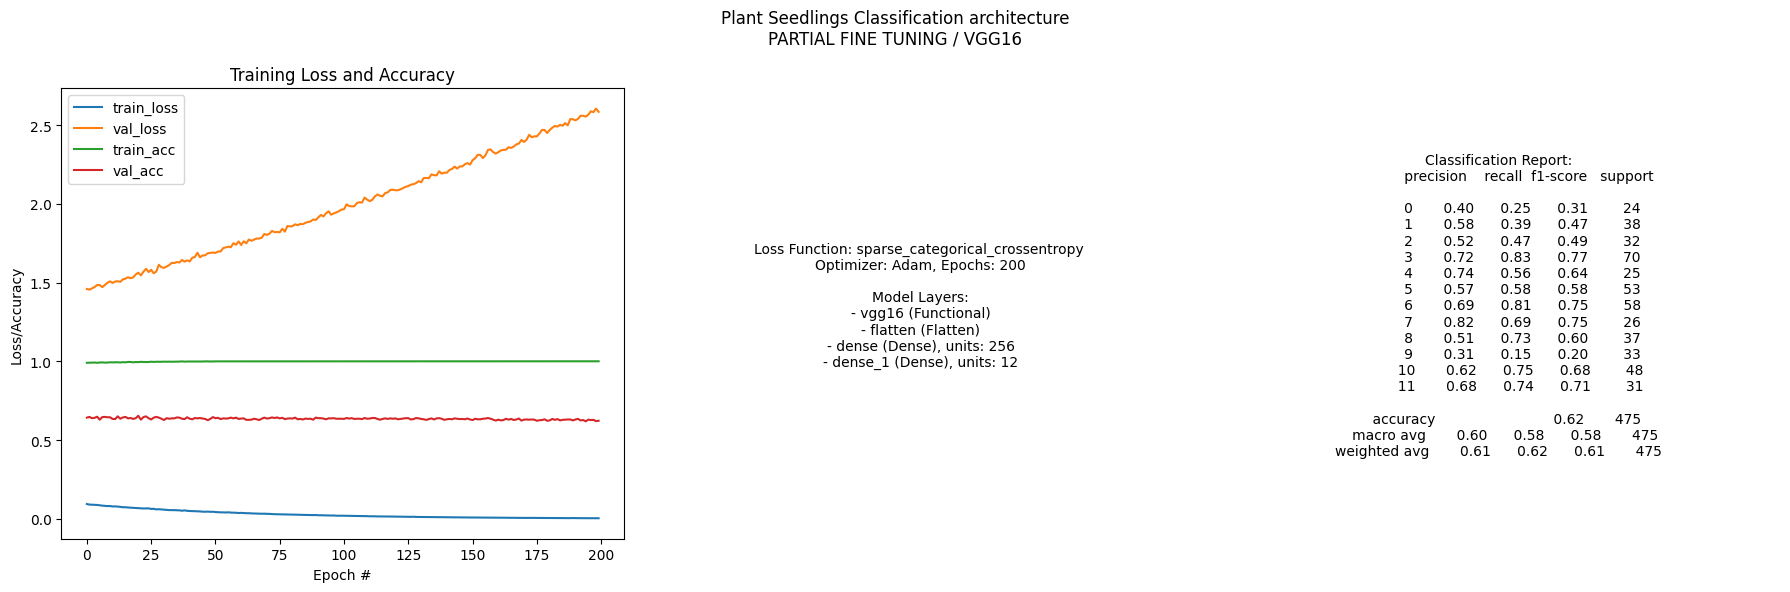

CPU times: user 1min 58s, sys: 13 s, total: 2min 11s
Wall time: 2min 43s


9874

In [ ]:
%%time
from tensorflow.keras import backend as K
import gc


pre_trained_model_VGG16.compile(optimizer=Adam(learning_rate=0.0001),
                                loss="sparse_categorical_crossentropy",
                                metrics=["accuracy"]
                                )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_VGG16.fit(x_tr, y_tr, epochs=200, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_VGG16, H, x_test, y_test, custom_text="PARTIAL FINE TUNING / VGG16")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()

![Experimento 5.2](https://datosysoluciones.com/viu/exp29.png)

Los resultados fueron un 100% en entrenamiento y un 62% en validación. que es un resultado razonable al igual que con el modelo ResNET, ya que los datos de ImagiNet son muy difernetes a nuestros datos.

FINE TUNING *COMPLETO*/ VGG16


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers



base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(tamano_image, tamano_image, 3),
    pooling=None,
    classifier_activation="softmax",
)


# Cargar la arquitectura y pesos de ResNet50 preentrenada en ImageNet
base_model_VGG16 = base_model

#TOP MODEL

pre_trained_model_VGG16  = Sequential(base_model_VGG16)

pre_trained_model_VGG16.add(layers.Flatten())
pre_trained_model_VGG16.add(layers.Dense(256, activation="relu"))
pre_trained_model_VGG16.add(layers.Dense(12, activation="softmax"))


#pre_trained_model_resnet.add(layers.GlobalMaxPooling2D())
#pre_trained_model_resnet.add(layers.Dropout(0.10))
#pre_trained_model_resnet.add(layers.Dense(12, activation="softmax"))


# Visualizar la estructura del modelo completo
pre_trained_model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 15242316 (58.14 MB)
Trainable params: 15242316 (58.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


[INFO]: Entrenando la red neuronal...
Epoch 1/25
72/72 [==============================] - 6s 30ms/step - loss: 1.6165 - accuracy: 0.4395 - val_loss: 1.0094 - val_accuracy: 0.6409
Epoch 2/25
72/72 [==============================] - 2s 25ms/step - loss: 0.8123 - accuracy: 0.7202 - val_loss: 0.6582 - val_accuracy: 0.7591
Epoch 3/25
72/72 [==============================] - 2s 25ms/step - loss: 0.5370 - accuracy: 0.8099 - val_loss: 0.8793 - val_accuracy: 0.6971
Epoch 4/25
72/72 [==============================] - 2s 25ms/step - loss: 0.4041 - accuracy: 0.8614 - val_loss: 0.4776 - val_accuracy: 0.8339
Epoch 5/25
72/72 [==============================] - 2s 25ms/step - loss: 0.2477 - accuracy: 0.9094 - val_loss: 0.3904 - val_accuracy: 0.8655
Epoch 6/25
72/72 [==============================] - 2s 25ms/step - loss: 0.2094 - accuracy: 0.9254 - val_loss: 0.5645 - val_accuracy: 0.8187
Epoch 7/25
72/72 [==============================] - 2s 25ms/step - loss: 0.1447 - accuracy: 0.9482 - val_loss: 0.375

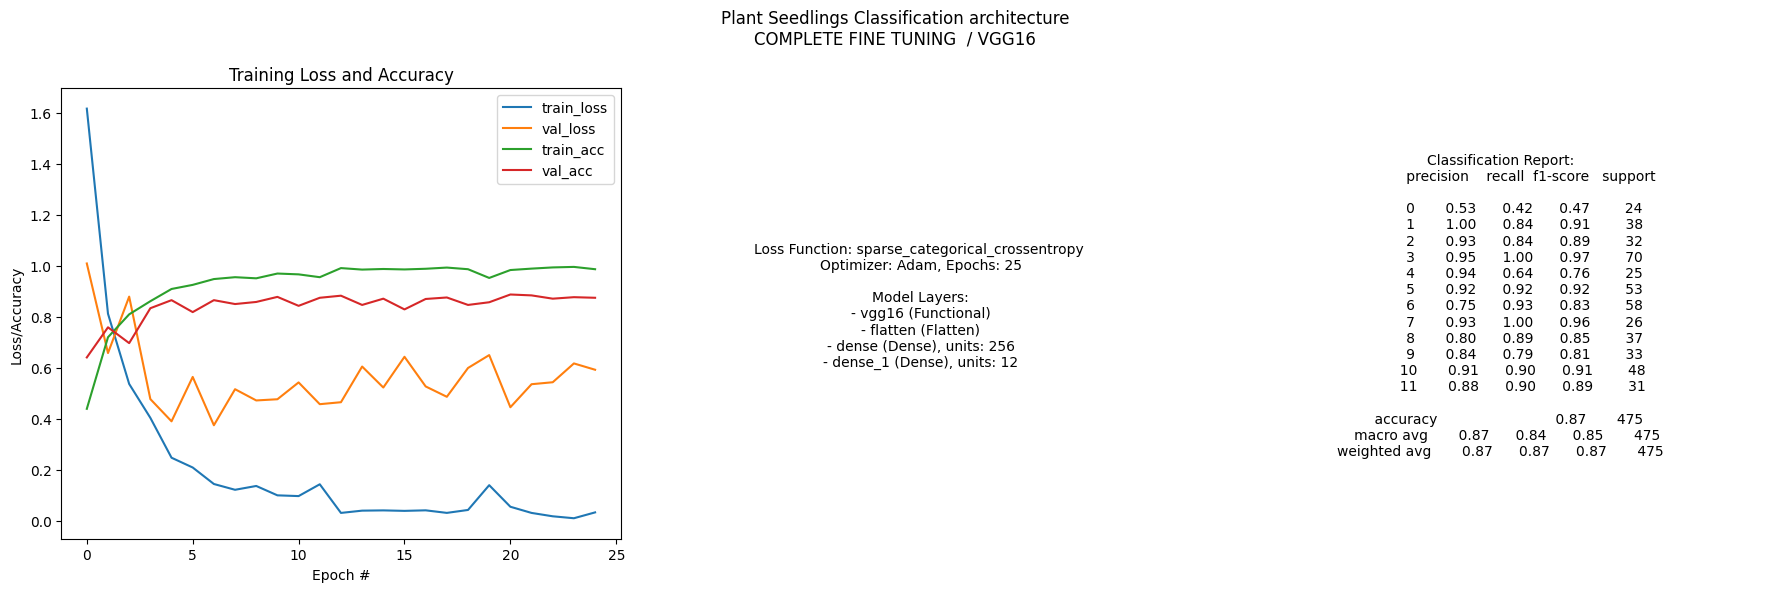

CPU times: user 47.2 s, sys: 2.7 s, total: 49.9 s
Wall time: 52.4 s


18007

In [ ]:
%%time
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

pre_trained_model_VGG16.compile(optimizer=Adam(learning_rate=0.0001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

print("[INFO]: Entrenando la red neuronal...")
H = pre_trained_model_VGG16.fit(x_tr, y_tr, epochs=25, batch_size=48, validation_split=0.2)

# Learning curves
visualize_and_evaluate_model(pre_trained_model_VGG16, H, x_test, y_test, custom_text="COMPLETE FINE TUNING  / VGG16")

#limpiamos sesiones para liberar RAM de GPU
K.clear_session()
gc.collect()

![Experimento 5.2](https://datosysoluciones.com/viu/exp31.png)

Los resultados fueron un 98% en entrenamiento y un 87% en validación. Esperábamos un comportamiento mejor, porque la arquitectura de VGG16 se parece un poco a la usada en nuestros experimentos, Las técnicas de regulación que usamos en nuestra arquitectura funcionan mejor que las de VGG16, para nuestros datos específicos

<center><b><br><h2>
Conclusiones
</center></b></h2>

-  De las pruebas que realizamos encontramos que utilizar otra red para realizar tareas de transfer learning y fine tunning no resultaron tan efectivas como los experimentos anteriores, esto podría deberse a que el conjunto de datos tiene imágenes de plantas en específico y los conjuntos de datos de las redes utilizadas son entrenadas con espectros de imágenes más amplios

- El Modelo RESNET es una arquitectura mas adecuada para segmentación por lo que su comportamiento con nuestros datos no es el deseado.
-
-
-